## Overview

We'll fit a Gaussian process model $Z(\boldsymbol{s})$ of the form

\begin{align*}
\mathbb{E}\left\{Z(\boldsymbol{s})\right\} &= \beta_1 + 
      \beta_2 x_1(\boldsymbol{s})\\
\mathrm{Cov}\left\{Z(\boldsymbol{s}), Z(\boldsymbol{u})\right\} &= 
    \sigma^2\left[\exp\left\{-\frac{1}{\theta}\left\|\boldsymbol{s}-\boldsymbol{u}\right\|\right\} + \eta\right],
\end{align*}

to a data set consisting of log zinc concentrations (ppm) sampled across a flood plain of the river Mesuse. Here, $x_1(\boldsymbol{s})$ represents the square root of the distance from $\boldsymbol{s}$ to the river.

The data is part of the sp R-library 

*Pebesma Edzer J., Bivand Roger S.* Classes and methods for spatial data in R
// R News. November 2005. 5, 2. 9–13.

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from bbai.gp import BayesianGaussianProcessRegression, Power1CovarianceFunction
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
import time
import rdata
import requests
import tempfile

## Load Data Set

In [2]:
def read_file(url):
    tfile = tempfile.NamedTemporaryFile()
    tfile.write(requests.get(url).content)
    parsed = rdata.parser.parse_file(tfile.name)
    return rdata.conversion.convert(parsed)

In [3]:
# Read training data
url = 'https://github.com/edzer/sp/raw/main/data/meuse.rda'
df = read_file(url)['meuse']
df = df[['x', 'y', 'dist', 'zinc']]
Z_train = np.array(df.iloc[:, :2]) / 1.0e3
y_train = np.log(np.array(df.iloc[:, -1]))
dist = df.iloc[:, 2:3]
X_train = np.hstack((np.ones((len(Z_train), 1)), np.sqrt(dist)))

In [4]:
# Read test data
url = 'https://github.com/edzer/sp/raw/main/data/meuse.grid.rda'
df = read_file(url)['meuse.grid']
df = df[['x', 'y', 'dist']]
Z_test = np.array(df.iloc[:, :2]) / 1.0e3
dist = df.iloc[:, 2:3]
X_test = np.hstack((np.ones((len(Z_test), 1)), np.sqrt(dist)))

Text(0.5, 1.0, 'Sampling Locations')

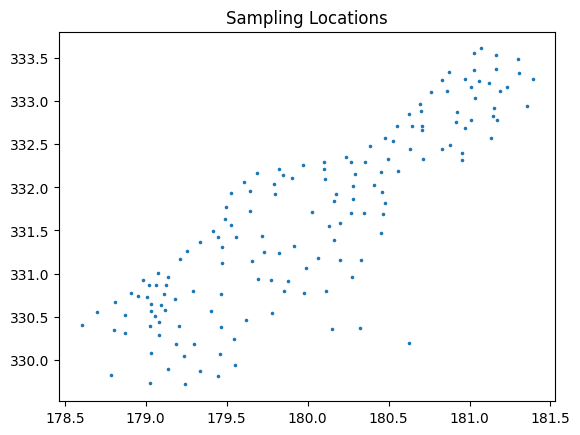

In [5]:
plt.scatter(Z_train[:, 0], Z_train[:, 1], s=2.5)
plt.title("Sampling Locations")

Text(0.5, 1.0, 'Prediction Locations')

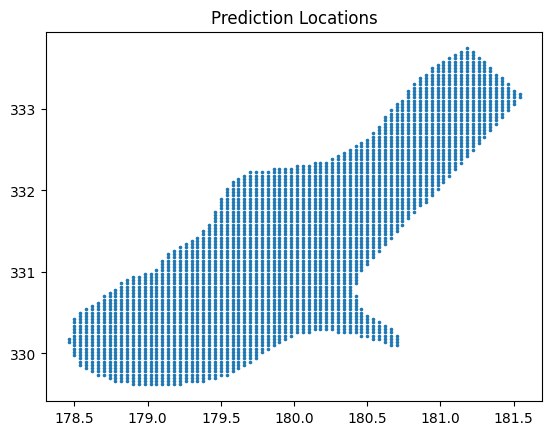

In [6]:
plt.scatter(Z_test[:, 0], Z_test[:, 1], s=2.5)
plt.title("Prediction Locations")

## Fit Model

In [7]:
model = BayesianGaussianProcessRegression(kernel=Power1CovarianceFunction())
t1 = time.time()
model.fit(Z_train, y_train, X_train)
t2 = time.time()
print('elapse: ', t2 - t1)

elapse:  1.2211196422576904


## Plot Sparse Grid

Text(0, 0.5, 'Log Noise Ratio')

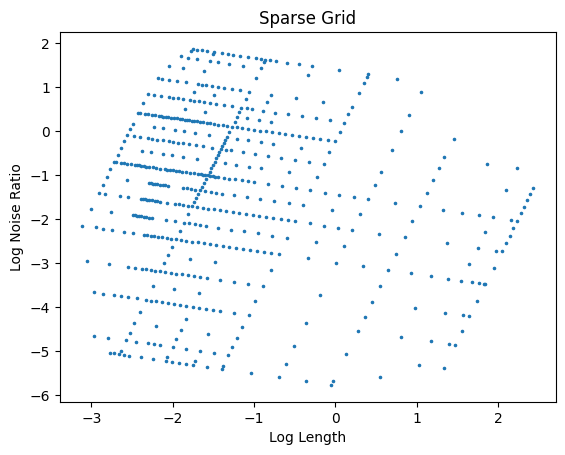

In [8]:
plt.scatter(model.hyperparameter_matrix_[0, :], model.hyperparameter_matrix_[1, :], s=2.5)
plt.title('Sparse Grid')
plt.xlabel('Log Length')
plt.ylabel('Log Noise Ratio')

## Plot Marginal Length

median length = 0.21886028518220396


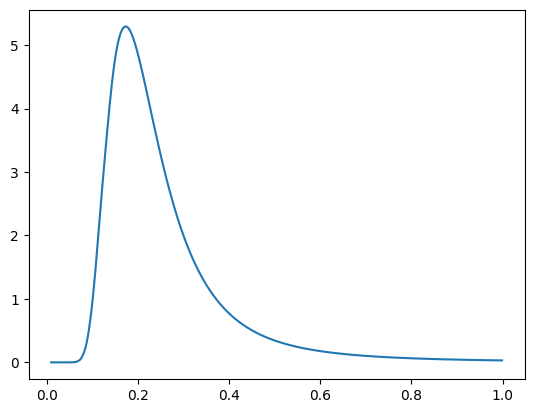

In [9]:
m = model.marginal_length_
lx = np.arange(0.01, 1, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median length =', m.ppf(0.5))

## Plot Marginal Noise Ratio

median noise ratio = 0.3075599709382165


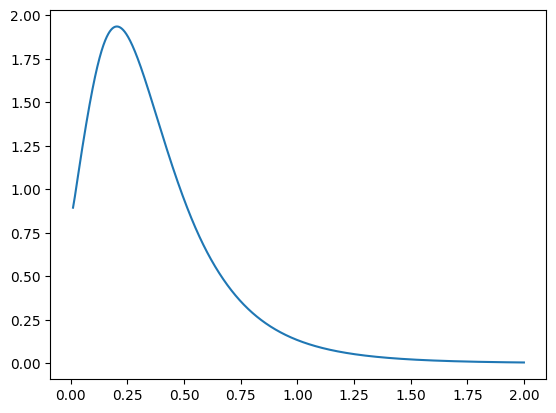

In [10]:
m = model.marginal_noise_ratio_
lx = np.arange(0.01, 2.0, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median noise ratio =', m.ppf(0.5))

## Plot Marginal of Sigma2 Signal

median sigma2-signal = 0.16428440901890862


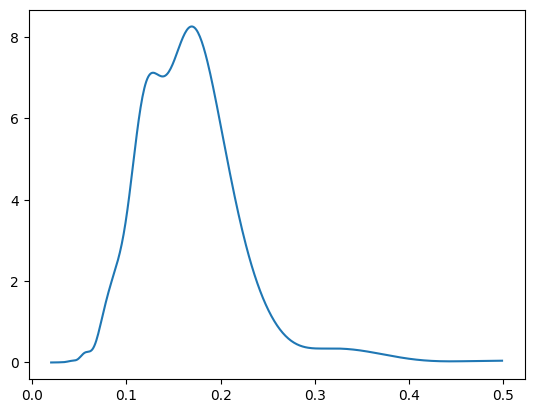

In [11]:
m = model.marginal_sigma2_signal_
lx = np.arange(0.02, 0.5, 0.001)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median sigma2-signal =', m.ppf(0.5))

## Plot Marginals $\beta$

median beta_1 = 6.985164732105164


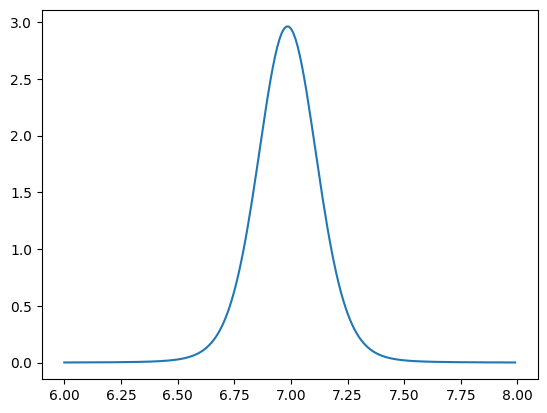

In [12]:
m = model.marginal_regressors_[0]
lx = np.arange(6, 8, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median beta_1 =', m.ppf(0.5))

median beta_2 = -2.5609835895053945


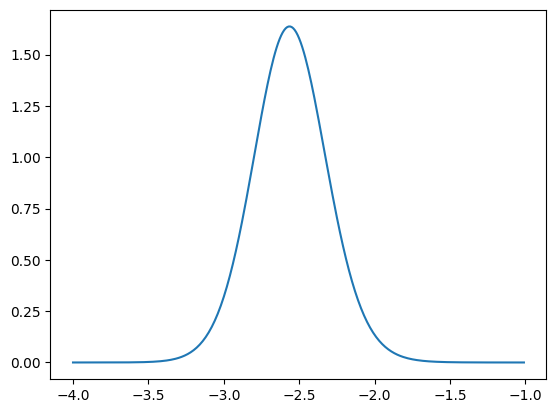

In [13]:
m = model.marginal_regressors_[1]
lx = np.arange(-4, -1, 0.01)
px = np.array([m.pdf(li) for li in lx])
plt.plot(lx, px)
print('median beta_2 =', m.ppf(0.5))

## Plot Predictions

In [14]:
pred, pred_pdfs = model.predict(Z_test, X_test, with_pdf=True)

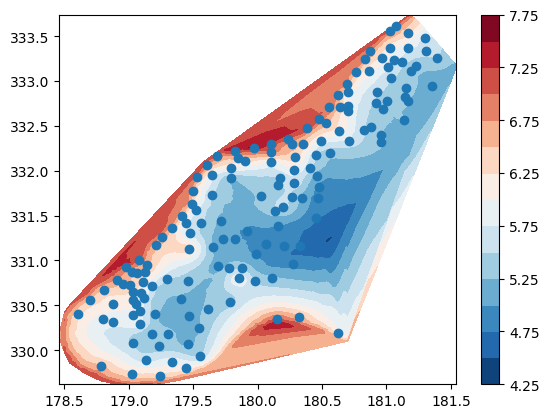

In [15]:
plt.tricontourf(Z_test[:, 0], Z_test[:, 1], pred, levels=14, cmap='RdBu_r')
plt.colorbar()
plt.scatter(Z_train[:, 0], Z_train[:, 1])

In [16]:
low = 0.025
lengths = pred_pdfs.ppf(1.0 - low) - pred_pdfs.ppf(low)

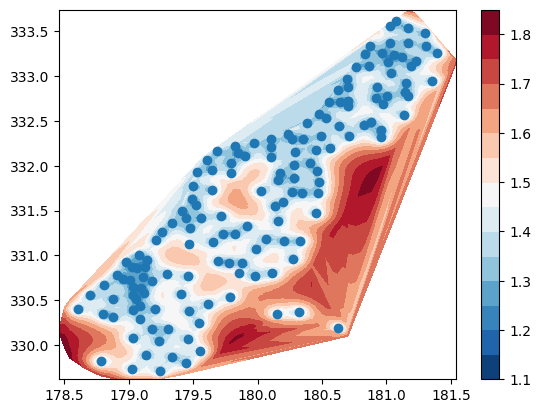

In [17]:
plt.tricontourf(Z_test[:, 0], Z_test[:, 1], lengths, levels=14, cmap='RdBu_r')
plt.colorbar()
plt.scatter(Z_train[:, 0], Z_train[:, 1])